### Standardize anomalies and define extremes

This notebook loads the data from [00_preprocess.ipynb](00_preprocess.ipynb) and detects extremes values. Detrended anomalies are standardized by the monthly mean standard deviation and extreme negative values are identified using the 10th percentile at each spatial point.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Import data
- preprocessed monthly averaged and optionally detrended OISST v2.1 data.


In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/preprocessed_OISSTv21.nc')
ds = xr.open_mfdataset(file_path_list)
ds

<xarray.Dataset>
Dimensions:       (lat: 720, lon: 1440, time: 478)
Coordinates:
  * time          (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat           (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon           (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    lsmask        (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    ssta_notrend  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_trend    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mean          (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    trend         (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    seas          (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  preprocessed monthly averaged OISST v2.1 anomalies

#### Standardize SST anomalies by dividing by the monthly standard deviatoin
This places equal variance on SSTa at all spatial points

In [9]:
# compute monthly standard deviation
stdev_notrend = ds.ssta_notrend.groupby(ds.time.dt.month).std()
stdev_trend = ds.ssta_trend.groupby(ds.time.dt.month).std()

# divide by standard deviation
ssta_stn_notrend = ds.ssta_notrend.groupby(ds.time.dt.month)/stdev_notrend
ssta_stn_trend = ds.ssta_trend.groupby(ds.time.dt.month)/stdev_trend


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]
/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


#### Calculate 10th percentile threshold from the origonal detrended SST anomalies

In [10]:
# Define extreme threshold as the 90th percentile
thresh = .1

# Rechunk time dim
if ssta_stn_notrend.chunks:
    ssta_stn_notrend = ssta_stn_notrend.chunk({'time': -1})
    ssta_stn_trend = ssta_stn_trend.chunk({'time': -1})
    
# Compute values of the monthly threshold
prct_notrend = ds.ssta_notrend.groupby(ds.time.dt.month).quantile(thresh, dim='time', keep_attrs=True, skipna=True)
prct_trend = ds.ssta_trend.groupby(ds.time.dt.month).quantile(thresh, dim='time', keep_attrs=True, skipna=True)


#### Find SSTA below the 10th percentile threshold

In [11]:
mcs_ssta_notrend = ds.ssta_notrend.groupby(ds.time.dt.month).where(ds.ssta_notrend.groupby(ds.time.dt.month)<=prct_notrend)
mcs_ssta_trend = ds.ssta_trend.groupby(ds.time.dt.month).where(ds.ssta_trend.groupby(ds.time.dt.month)<=prct_notrend)


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]
/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


#### Quick sanity check


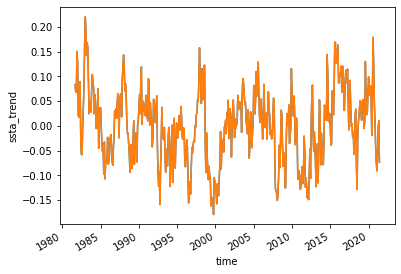

In [22]:
ds.ssta_notrend.mean(('lat','lon')).plot()
ds.ssta_trend.mean(('lat','lon')).plot()

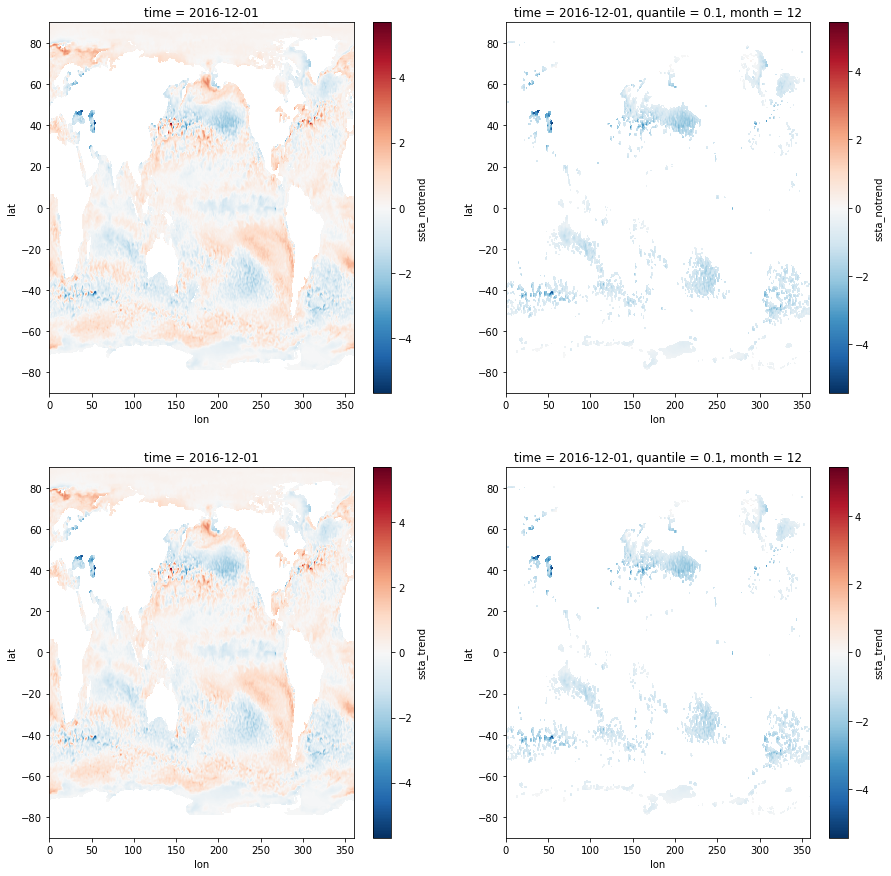

In [21]:
fig, ax = plt.subplots(2,2,figsize=(15,15))
ds.ssta_notrend.sel(time=('2016-12-01')).plot(ax=ax[0][0])
mcs_ssta_notrend.sel(time=('2016-12-01')).plot(ax=ax[0][1])
ds.ssta_trend.sel(time=('2016-12-01')).plot(ax=ax[1][0])
mcs_ssta_trend.sel(time=('2016-12-01')).plot(ax=ax[1][1]);

### Save output 

In [7]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_new = xr.Dataset(
    data_vars=dict(
        ssta_stn_notrend=(['time', 'lat', 'lon'], ssta_stn_notrend.data),
        prct_notrend = (['month','lat', 'lon'], prct_notrend.data),
        mcs_ssta_notrend = (['time', 'lat', 'lon'], mcs_ssta_notrend.data),
        
        ssta_stn_trend=(['time', 'lat', 'lon'], ssta_stn_trend.data),
        prct_trend = (['month','lat', 'lon'], prct_trend.data),
        mcs_ssta_trend = (['time', 'lat', 'lon'], mcs_ssta_trend.data),
        
    ),
    coords=dict(
        month=(['month'], prct_notrend.month.data),
        time=(['time'], ds.time.data),
        lat=(['lat'], ds.lat.data),
        lon=(['lon'], ds.lon.data),
    ),
    attrs=dict(description="standardized SST anomalies below negative extreme threshold", 
               threshold=thresh, 
               data='preprocessed monthly averaged OISST v2.1'),
)

ds_new.to_netcdf(path+'negative_extremes_OISSTv21.nc', mode='w')

NameError: name 'mhw_ssta_notrend' is not defined